<a href="https://colab.research.google.com/github/sensiml/AnalyticStudioTutorials/blob/master/sensiml_keyworld_spotting_recognition_with_tensorflow_lite_micro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

## SensiML Python Client

We are going to connect to SensiML's cloud engine using the SensiML Development Python Client. If you have not yet created an account on SensiML you will need to do that before continuing. You can create a free account by going here

To install the client in the colab enviornment run the command in the following cell.

In [ ]:
!pip install sensiml-dev -U

Next, import the SensiML python client and use it to connect to SensiML Cloud.  Run the following cell, which will ask you for your username and password. After connecting, you will be able to use the python client to manage the data in your project, create queries, build and teset models as well as download firmware. Further documentation for using the python client can be found [here](https://sensiml.com/documentation/api-methods/overview.html).

In [3]:
from sensiml import *
import sensiml.tensorflow.utils as sml_tf

Next we are going to connect to our **Keyword Spotting - Demo** Project. Run the following cell to connect to the proejct using the python client. 

In [ ]:
dsk = SensiML()


In [ ]:
dsk.project =  <Youre Project Name>

### Data Exploration

Lets look at the summary of the data. If you are on the free tiral, there is already created a Query for this project, othewrise you can build and create queries in the [SensiML Analytic Studio](https://app.sensiml.cloud). Queries describe the data that will go into the pipeline. Run the following cells to see the names of the queries in the project along with a visualization that summarizes for each class the number of labeled events in the project.

In [8]:
dsk.list_queries()

,Name,Created,UUID
0,Q1,2020-03-06 19:35:59,bd8df215-003a-41be-90b0-e845dded87df


### Pipelines

Pipelines are a key component of the SensiML workflow. Pipelines store the preprocessing, feature extraction and model building steps. When training a model, these steps are executed on the SensiML server. Once the model has been trained, the pipeline is converted to firmware code that will run on your target embedded device. For more documentation on pipelines see the advanced model building [tutorial](https://sensiml.com/documentation/advanced-model-building/advanced-model-building.html). To create a new empty pipeline, run the cell below.

In [9]:
dsk.pipeline = <Your Pipeline name>

Sandbox test does not exist, creating a new sandbox.


If a pipeline with that name does not exist, a new one will be created on the server. Otherwise it will connect to a previously created pipeline.

Now we are going to add our preprocessing steps to the pipeline, for a detailed description of the features available in a pipeline see the documentation [here](https://sensiml.com/documentation/pipeline-functions/overview.html). You can also list the functions by running ```dsk.list_functions(qgrid=False, functype="Feature Generator")```

### Creating a Query

In [18]:
# Get the list of sessions/segmentation algorithms
dsk.list_segmenters()

,id,parent,name,function,parameters,custom,preprocess,created_at,last_modified
0,2540,None,google,None,None,True,None,2020-03-03T06:00:17.168616Z,2020-03-03T06:00:17.168645Z
1,2545,None,AutoSegment,None,"{""inputs"":{""input_data"":"""",""column_of_interest...",False,{},2020-03-04T19:52:37.450643Z,2020-03-04T19:53:42.500910Z


In [ ]:
#create the query
dsk.create_query(
    "Q1",
    label_column="Label",
    columns=[
        "Microphone",
    ],
    metadata_columns=["Subject", "segment_uuid"],
    segmenter="AutoSegment",
)

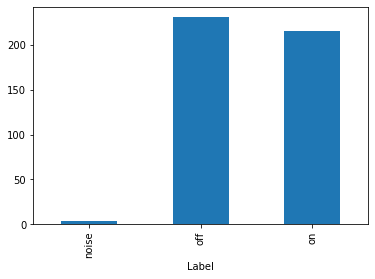

In [19]:
# see the number of segments in the query
q = dsk.get_query("Q1")
q.statistics_segments().groupby('Label').size().plot(kind='bar')


### Assembling a pipeline 

The pipeline for this tutorial will consist of the following steps:

1.   The **Input Query** which specifies what data is being fed into the model
2.   The **Feature Generators** which specify which features should be extracted from the raw time series data
3.   The **Feature Transform** which specify how to transform the features after extraction. In this case it is to scale them to 1 byte each
4.   The **Feature Selector** which selects the best features. In this case we are using the custom feature selector to downsample the data. 


The code in the following cell sets our initial variables, then specifies each step in the pipeline. For now, you don't need to dig into each of these steps, but just know that the end result will be a feaure vector scaled to 1 byte values for each of the segments that were labeled in the Data Capture Lab. We will use these features as input to our tensorflow model.

In [27]:
dsk.project.columns()

dict_keys(['Microphone'])

In [28]:
num_cols=12
row_size=10

dsk.pipeline.reset()
dsk.pipeline.set_input_query("Q1")

dsk.pipeline.add_transform("Windowing", params={"window_size": 400,
                                                "delta": 400,
                                                "train_delta": 0,
                                                "return_segment_index": False,
                                                })

dsk.pipeline.add_feature_generator([{'name':'MFCC', 'params':{"columns": ["Microphone"],
                                    "sample_rate": 16000,
                                    "cepstra_count": num_cols,
                                    }}])

dsk.pipeline.add_transform("Feature Cascade", params={"num_cascades": row_size ,
                                "slide": True,
                                })

dsk.pipeline.add_transform("Min Max Scale", params={"min_bound": 0,
                                "max_bound": 255,
                                "pad": 0,
                                "feature_min_max_defaults":{'minimum':-500000, 'maximum':500000.0},
                                })

To see the steps currently added to your pipeline you can use the describe method

In [29]:
dsk.pipeline.describe()

------------------------------------------------------------------------
 0.     Name: Q1                        		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
	group_columns: ['Label', 'Subject', 'segment_uuid']
	window_size: 400
	delta: 400
	train_delta: 0
	return_segment_index: False
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
	 0. Name: MFCC                     
	group_columns: ['Label', 'SegmentID', 'Subject', 'segment_uuid']
------------------------------------------------------------------------
 3.     Name: Feature Cascade       

### Executing a Pipeline

At this point the pipeline has not been executed yet, we are just assemebling the steps. To run the pipeline, execute the following cell. This will print out a summary of the pipeline steps that are being run followed by the status of the pipeline execution on the server.

Once the pipeline is finished running, the results will be stored in the variable *fv_t*. A summary of the execution is stored in the *s_t* variable. 


The pipeline will report status updates tell youing which step is currently running, how many batches (parallel steps) have been run and how many steps are left. This process is asyncrhonous, so if you get disconnected you can run the dsk.pipeline.get_results() to check the status of your pipeline.

Another thing to note is that intermediate steps are cached. you can retrieve data from intermediate steps by using dsk.pipeline.data(<index_of_step>). If you make any changes to your pipeline, only steps after the change will need to rerun.


In [31]:
fv_s, s= dsk.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: Q1                        		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Feature Cascade           		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: M

FeatureGenerationError: MFCC threw an exception so it was dropped ('channel0')




Results Retrieved... Execution Time: 0 min. 0 sec.


## SensiML Features and Tensorflow Model

Now we have our features for this model, we will go ahead and train a Tensorflow Model in the colab enviornment. We will start by splitting our dataset into train, test and validate groups. The python client has a built-in function for performing this split. You can also pass in the validation data test sizes. By default, they are set to 10% each.

In [32]:


x_train, x_validate, x_test, y_train, y_validate, y_test,  class_map = \
    dsk.pipeline.features_to_tensor(fv_s, test=.1, validate=.1)

-----  Summary  -----
Class Map: {'noise': 0, 'off': 1, 'on': 2}
Train:
 total:  359
 by class: [  2. 185. 172.]
Validate:
 total:  46
 by class: [ 1. 23. 22.]
Train:
 total:  44
 by class: [ 0. 23. 21.]


### Feature Visualization
Lets take a quick look at the features that we have created. Run the following cell to see the heatmap (left) along with the raw features (right).  To switch which event you are looking at change the event_index.

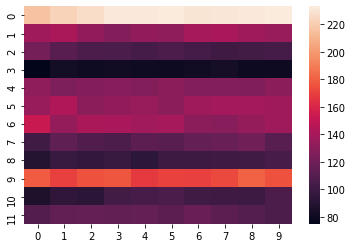

In [34]:
import seaborn as sn
event_index=50
sn.heatmap(x_train[event_index].reshape(row_size,-1).T)

### Data Augmentation

It is often useful to perform data augmentation to make models more robust to unseen data. One data augmentation strategy is to apply masks in the feature space. For this tutorial, we will add masks randomly across time and sensors. To implement the masking in tensorflow we use the tf.data API. The steps in the following cell are described by:

1.   Specify variables which describe the properites of our masking
2.   Convert our training dataset that is currently a dataframe into a tf.data bject
3.   Add a noise layer which randomly adds noise to the features.
4.   Apply a time mask will randomly mask up to rand_max time slices.
5.   Apply a sensor mask which will randomly mask up to rand_max sensors
6.   Apply a shuffler which will randomize our dataset after each training iteraion.

For more information about the tf.data.DataSet see the documentation [here](https://www.tensorflow.org/guide/data)

In [36]:
rand_max = 1
min_noise=-10
max_noise=10
mask_value=127
batch_size =32

data  = tf.data.Dataset.from_tensor_slices((x_train, y_train))
noise_ds = data.map(lambda image, label: sml_tf.add_image_noise(image, label, rand_max, min_noise, max_noise))
freq_ds = noise_ds.map(lambda image, label: sml_tf.mask_image_row(image, label, rand_max, num_cols, mask_value))
masked_ds = freq_ds.map(lambda image, label: sml_tf.mask_image_column(image, label, row_size, rand_max, num_cols, mask_value))


# Augmented Data
shuffle_aug = masked_ds.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(batch_size)

# Shuffled Data
shuffle_ds = data.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(batch_size)

To visualize the tf data you can use this helper function, switch the idnex to look at differtn feature maps.

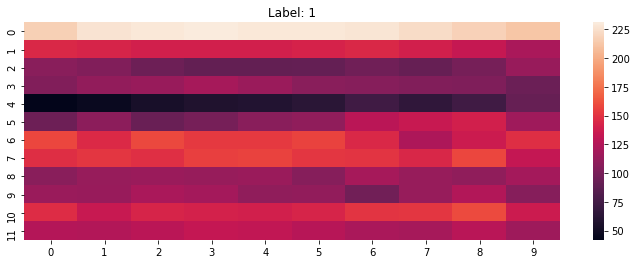

In [37]:
sml_tf.visualize_tf_data(masked_ds, index=7, row_size=row_size, num_cols=num_cols)

### Specifying the Tensorflow Model

The Next step is to define what our tensorflow model looks like. For this tutorial we are going to use the Tensorflow Keras API to create a [Convolution Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN). When you are building a model to deploy on a microcontroller, it is important to remember that all functions of tensorflow are not suitable for a micro controller. Additionally, only a subset of Tensorflow functions are availible as part of Tensorflow Lite Micro. For a full list of available functions see the [all_ops_resolver.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/kernels/all_ops_resolver.cc). 

For this tutorial use a 1D convolution followed by a 2D convolution and finaly a fully connected layer to efficiently classify the boxing gestures. Our aim is to limit the number and size of every layer in the model to only those necessary to get our desired accuracy. Often you will find that you need to make a trade off between latency/memory usage and accuracy in order to get a model that will work well on your microcontroller.


In [41]:
optimization_metric = "accuracy"
# We'll use Keras to create a simple model architecture
from tensorflow.keras import layers
import tensorflow as tf

tf_model = tf.keras.Sequential()
tf_model.add(layers.Reshape((10, 12, 1), input_shape=(120,)))
tf_model.add(layers.Conv2D(32, (2, 6), padding="valid", activation="relu",  strides=[2,2]))
tf_model.add(layers.MaxPool2D((2, 2)))
tf_model.add(layers.Dropout(0.1))
tf_model.add(layers.Conv2D(16, (2, 2), padding="valid", activation="relu"))
#tf_model.add(layers.Dropout(0.1))
#print(tf_model.summary())
#tf_model.add(layers.MaxPool2D((1, 2), padding="valid"))
tf_model.add(layers.Flatten())
# Final layer is a single neuron, since we want to output a single value
tf_model.add(layers.Dense(18, activation='relu', ))
tf_model.add(layers.Dense(len(class_map.keys()), activation='sigmoid'))
# Compile the model using a standard optimizer and loss function for regression
tf_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[optimization_metric])
tf_model.summary()

train_history = {'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 12, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 4, 32)          416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 16)          2064      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)               

### Training the Tensorflow Model

After defining the model graph, it is time to train the model. Training a NN consists of iterating through batches of your traning dataset multiple times, each time it loops through the entire training set is called an epoch. For each batch of data, the loss function is computed and the weights of the layers in the network are adjusted.  

The following cell will loop through the training data num_iterations of times. Each time running a specific number of epochs. After each iteration, the visualizations for the loss, accuracy and confusion matrix will be updated for both the validation and training data sets. You can use this to see how the model is progressing. 

Sometimes the intialization of the model gets stuck in a bad state, we put a check in that will call reset_weights to reinitialize the network weights if the model is stuck in a low accuracy state. Other methods could be to adjust the learning rate. If your reaches the desired accruacy before the training completes, hit the stop button at the left side of the cell and you can continue the tutorial with the model at its current state. 

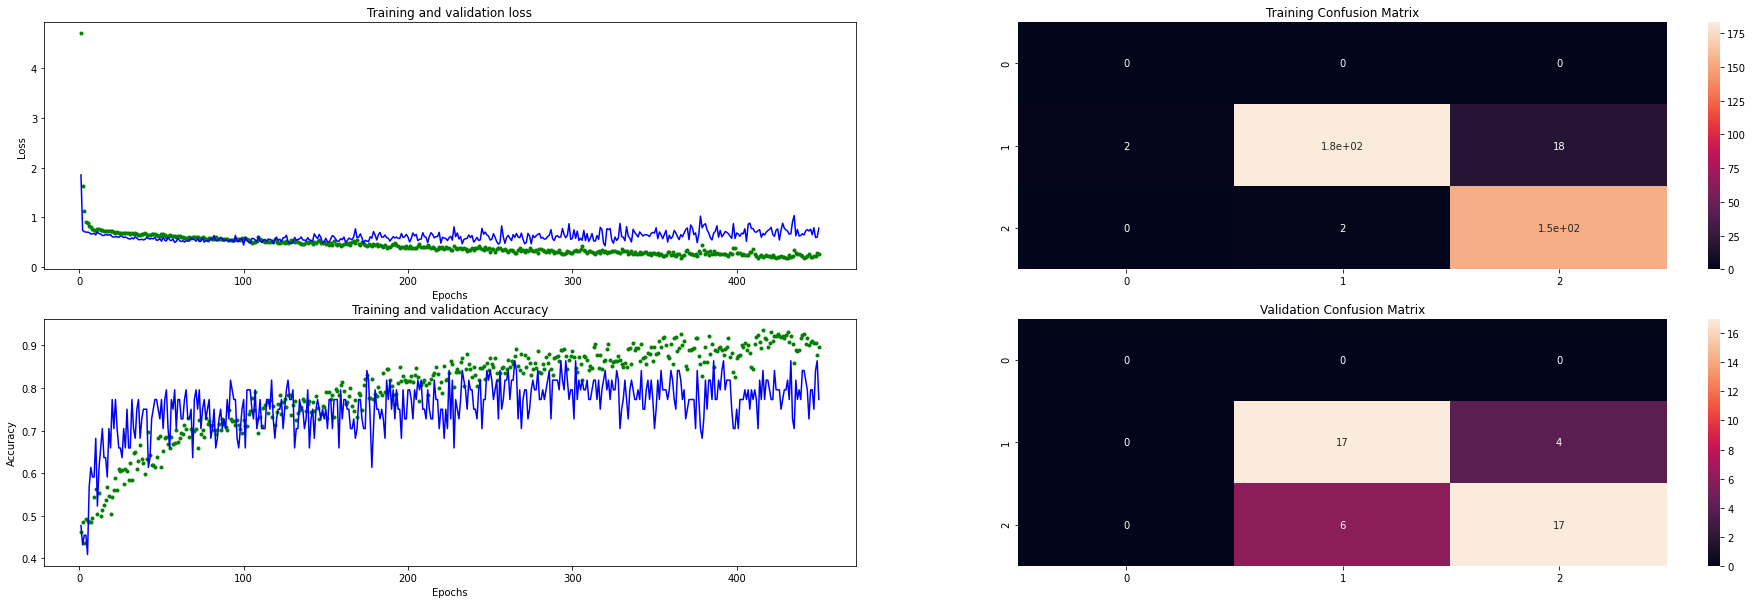

KeyboardInterrupt: ignored

In [42]:
from IPython.display import clear_output

num_iterations=10
for i in range(num_iterations):
    history = tf_model.fit( shuffle_aug, #shuffle_ds
                              epochs=50,
                              batch_size=batch_size, 
                              validation_data=(x_validate, y_validate),
                              verbose=0)
    clear_output()    

    for key in train_history:
        train_history[key].extend(history.history[key])

    sml_tf.plot_training_results(tf_model, train_history, x_train, y_train, x_validate, y_validate)

    if train_history['accuracy'][-1] <= .3 and train_history['accuracy'][-25] <= (train_history['accuracy'][-1]+5):
        print('reinitializing weights')
        sml_tf.reset_weights(tf_model)
        train_history = {'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}

### Qunatize the Tensorflow Model

Now that you have trained a neural network with tensorflow, we are going to use the built-in tools to quantize it. Quantization of NN allows use to reduce the model size by up to 4x by converting the network weights from 4-byte floating point values to 1-byte uint8. This can be done without sacrificing much in terms of accuracy. The best way to perform quantization is still an active area of research. For this tutorial, we will use the built-in methods that are provided as part of Tensorflow. 

*   The ```representative_dataset_generator()``` function is necessary to provide statistical information about your dataset ino order to quantize the model weights appropriatley. 
*   The TFLiteConverter is used to convert a tensorflow model into a tensor flow lite model. The tensorflow lite model is stored as a [flatbuffer](https://google.github.io/flatbuffers/) which allows us to easily store and access it on embedded systems.

In [55]:
def representative_dataset_generator():  
  for value in x_test:   
  # Each scalar value must be inside of a 2D array that is wrapped in a list    
    yield [np.array(value, dtype=np.float32, ndmin=2)]

# Unquantized Model
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model_full = converter.convert()
print("Full Model Size", len(tflite_model_full))

# Quantized Model
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.experimental_new_converter = False
converter.representative_dataset = representative_dataset_generator
tflite_model_quant = converter.convert()

print("Quantized Model Size", len(tflite_model_quant))

INFO:tensorflow:Assets written to: /tmp/tmpmucsuvlw/assets


INFO:tensorflow:Assets written to: /tmp/tmpmucsuvlw/assets


Full Model Size 15484
INFO:tensorflow:Assets written to: /tmp/tmp0cwnc5_1/assets


INFO:tensorflow:Assets written to: /tmp/tmp0cwnc5_1/assets


Quantized Model Size 8304


As you can see thethe Quantized model is significantly smaller than the unquantized model. An additional benifit of quantizing the model is that tensorflow lite micro is able to take advantage of specialized instructions on cortex M chips using the [cmsis-nn](http://www.keil.com/pack/doc/cmsis/NN/html/index.html) DSP library which gives another huge boost in performance. For more information on tensorflow lite for microcontrollers you can check out the execellent [tinyml](https://www.oreilly.com/library/view/tinyml/9781492052036/) book by Pete Warden.

Now that you have trained your model, its time to upload it as the final step in your pipeline. From here you will be able to test the entire pipeline against test data as well as download the firmware which can be flashed to run locally on your embedded device. To do this we will use the **Load Model TF Micro** function. We will convert the tflite model to and upload it to the SensiML Cloud server. 

*Note: An additional parameter that can specified here is the threshold. We set it to .2 in this examples. Any classification with a value less than the threshold will be returned as 0 which is reserved for an **unknown** classification.*

In [71]:
class_map_tmp = {k:v+1 for k,v in class_map.items()} #increment by 1 as 0 corresponds to unknown

dsk.pipeline.set_training_algorithm("Load Model TF Micro",
                                    params={"model_parameters": {'tflite': sml_tf.convert_tf_lite(tflite_model_quant)},
                                            "class_map": class_map_tmp,
                                            "estimator_type": "classification",
                                            "threshold": 0.9, # must be above this value otherwise is unknown
                                            })

dsk.pipeline.set_validation_method("Recall", params={})

dsk.pipeline.set_classifier("TF Micro", params={})

dsk.pipeline.set_tvo()

results, stats = dsk.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: Q1                        		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Feature Cascade           		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: M



Results Retrieved... Execution Time: 0 min. 0 sec.


### Model summary
After exectuing the pipeline, the cloud computes a model summary as well as a confusion matrix. The model summary gives a quick overview of the model performance so we can see what the accuracy of the quantized model was accross our data set.

In [65]:
results.summarize()

TRAINING ALGORITHM: Load Model TF Micro
VALIDATION METHOD:  Recall
CLASSIFIER:         TF Micro

AVERAGE METRICS:
                 F1_SCORE:  55.8  std: 0.00
                PRECISION:  56.9  std: 0.00
              SENSITIVITY:  55.4  std: 0.00

--------------------------------------

RECALL MODEL RESULTS : SET VALIDATION

MODEL INDEX: Fold 0
                 F1_SCORE:    train: 55.76  validation: 55.76  
              SENSITIVITY:    train: 55.40  validation: 55.40  



### Confusion Matrix

The confusion matrix provides information not only about the accuracy, but also what sort of missclassifications occured. The confusion matrix is often one of the best ways to understand how your model is performing, as you can see which classes are difficult to distinguish between. The confusion matrix here also includes the Sensitivity and Postitive Predictivity for each class along with the overal accuracy. If you raise the threshold value, you will notice that some of the class start showing up as having UNK values. This corresponds to an unknown class and is useful for filtering out False Postives or detecting anomalous states.

In [66]:
model = results.configurations[0].models[0]
model.confusion_matrix_stats['validation']

CONFUSION MATRIX:
               noise       off        on       UNK       UNC   Support   Sens(%)
     noise       0.0       1.0       0.0       2.0       0.0       3.0       0.0
       off       0.0     212.0      17.0       2.0       0.0     231.0      91.8
        on       0.0      51.0     160.0       4.0       0.0     215.0      74.4

     Total         0       264       177         8         0       449          

PosPred(%)       nan      80.3      90.4                        Acc(%)      82.9

*Finally*, we save the model knowledge pack with a name. This tells the server to persist this model, and will let us retrive and view the metrics in the future. Models that are not saved will be deleted when the pipeline is rerun. 

In [ ]:
model.knowledgepack.save("Tensorflow_model_1")

### Offline Model Validation

After saving your model, you can return back to the  [Analytic Studio](https://app.sensiml.cloud) to continue validating and generating your firmware. To test your model against any of the captured data files, 
, select the pipeline and 

1.   Go to the Explore Model tab of the Analytic Studio.
2.   Select the pipeline you built the model with.
3.   Select the model you want to test.
4.   Select any of the capture files in the Project.
5.   Click RUN to classify that capture using the selected model.

The model will be compiled in the SensiML Cloud and the output of the classification will be returned. The graph shows the segment start and segment classified for all of the detected events.

We can also test the model here by selecting a capture and running it through the model recognize_signal function

In [68]:
dsk.list_captures()

,Name,Created,UUID
0,off_7117fb6d_nohash_1.csv,2020-03-03T06:16:39.811606Z,62c72eb6-b905-4df8-9922-96d037d537fd
1,off_70a00e98_nohash_1.csv,2020-03-03T06:16:37.083128Z,d88c906e-5732-44f6-bdb2-8956d65fd414
2,off_7096522d_nohash_0.csv,2020-03-03T06:16:34.337949Z,724b3b70-94df-4cda-aef5-1a5f8011f9da
3,off_6fca237d_nohash_1.csv,2020-03-03T06:16:31.510154Z,47da8df7-83a3-47fc-8343-893d1dd4f3b4
4,off_6fb3d5a7_nohash_1.csv,2020-03-03T06:16:28.894291Z,3f299386-481a-4bcf-8dee-353586fb078f
...,...,...,...
770,off_129c7d8d_nohash_0.csv,2020-03-03T06:06:57.333658Z,ffc50819-816c-4287-a192-08b3adf10562
771,off_042186b8_nohash_0.csv,2020-03-03T06:06:18.219257Z,58e78d44-3381-40ab-84d7-992b62ec5fc3
772,off_0227998e_nohash_0.csv,2020-03-03T06:06:14.945909Z,7e067f9c-de03-4741-84c1-11f2bbc9f493
773,off_017c4098_nohash_4.csv,2020-03-03T06:06:12.572809Z,6a5060d3-1859-4152-bee0-87f779ccf940


In [69]:
res,s = model.recognize_signal(capturefile="off_017c4098_nohash_2.csv")


Status: Running, Time: 0.09, Executing recognize signal. ..

Results Retrieved... Execution Time: 0 min. 22 sec.
Results retrieved.


In [70]:
res

,Classification,ClassificationName,FeatureVector,ModelDebug,ModelName,SegmentEnd,SegmentID,SegmentLength,SegmentStart,Capture
0,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.359375, 0.722656, 0.703125]",0,399,0,400,0,off_017c4098_nohash_2.csv
1,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.359375, 0.722656, 0.703125]",0,799,1,400,400,off_017c4098_nohash_2.csv
2,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.476562, 0.703125, 0.640625]",0,1199,2,400,800,off_017c4098_nohash_2.csv
3,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.316406, 0.546875, 0.742188]",0,1599,3,400,1200,off_017c4098_nohash_2.csv
4,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.523438, 0.742188, 0.617188]",0,1999,4,400,1600,off_017c4098_nohash_2.csv
5,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.316406, 0.523438, 0.761719]",0,2399,5,400,2000,off_017c4098_nohash_2.csv
6,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.453125, 0.683594, 0.882812]",0,2799,6,400,2400,off_017c4098_nohash_2.csv
7,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.546875, 0.683594, 0.792969]",0,3199,7,400,2800,off_017c4098_nohash_2.csv
8,0,Unknown,"[127, 127, 127, 127, 127, 127, 127, 127, 127, ...","[0.570312, 0.835938, 0.835938]",0,3599,8,400,3200,off_017c4098_nohash_2.csv
9,0,Unknown,"[175, 116, 130, 127, 130, 132, 120, 137, 130, ...","[0.5, 0.617188, 0.792969]",0,3999,9,400,3600,off_017c4098_nohash_2.csv
